# Amazon Bedrock Batch Inference

## 背景
- Bedrockのbatch推論のquotaがon demandと関係ない（だからquotaに引っ掛からなくてうれしい）と言う説
- text to image (SDXL or Titan or Both)で500枚くらいバッチ推論ジョブを発行してどんな風に実行が完了するか（もしくは完了しないか）を見てみる
- On demandのquotaより明らかに早かったら嬉しい


## 検証条件
- 推論方式: バッチ
- 生成: テキスト → 画像
- モデル:
    - amazon.titan-image-generator-v1
    - stability.stable-diffusion-xl-v1

## 情報まとめ
### 公開情報
- 開発者ドキュメント: https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference.html
- Quota: https://docs.aws.amazon.com/bedrock/latest/userguide/quotas.html#quotas-batch
- コードサンプル: https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference-example.html

### 2024.1.25
- Public Preview
- 利用方法
    - REST API: あると思うが面倒
    - CLI: 無さそう
    - SDK: プレビューのがある
        - PythonとJavaのみ
        - https://d2eo22ngex1n9g.cloudfront.net/Documentation/SDK/bedrock-python-sdk-reinvent.zip
    - コンソール: 無さそう

## 共通条件設定

In [1]:
image_size:int = 1024

In [2]:
height:int = image_size
width:int = image_size

image_generation_config:dict = {
    # "numberOfImages": 1,
    # "quality": "standard",
    "height": height,
    "width": width,
    # "cfgScale": 8.0,
    # "seed": 0
}

## 単発推論

まずは単発を確認

サンプルコード: https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-image.html#model-parameters-titan-image-code-examples

In [3]:
prompt:str = "A dog running at a park."

from func import generate_image_by

INFO:func:Generating image with amazon.titan-image-generator-v1 model.
INFO:func:Successfully generated image with amazon.titan-image-generator-v1 model.


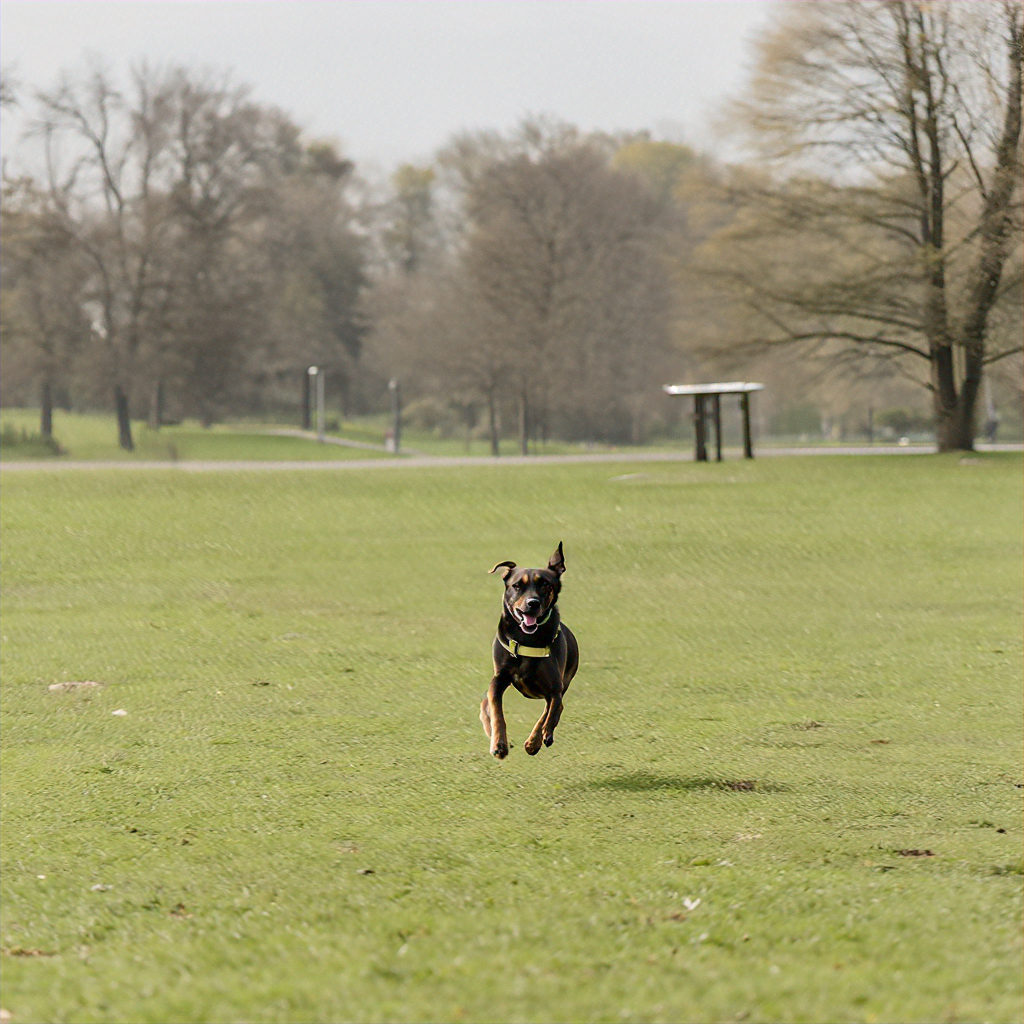

Finished generating image with amazon.titan-image-generator-v1 model.


In [4]:
body = {
    "taskType": "TEXT_IMAGE",
    "textToImageParams": {
        "text": prompt
    },
    "imageGenerationConfig": image_generation_config
}
generate_image_by(model_id="amazon.titan-image-generator-v1", body=body)

In [5]:
body = {
    "text_prompts": [{"text": prompt}],
    "height": height,
    "width": width,
    # "cfg_scale": float,
    # "clip_guidance_preset": string,
    # "sampler": string,
    # "samples",
    # "seed": int,
    # "steps": int,
    # "style_preset": string,
    # "extras" :JSON object
}
generate_image_by(model_id="stability.stable-diffusion-xl-v1", body=body)

INFO:func:Generating image with stability.stable-diffusion-xl-v1 model.


## 検証

### 環境準備

In [14]:
SDK = "sdk"
ZIP = f"{SDK}.zip"
! wget --no-check-certificate -O $ZIP https://d2eo22ngex1n9g.cloudfront.net/Documentation/SDK/bedrock-python-sdk-reinvent.zip

--2024-02-01 07:29:12--  https://d2eo22ngex1n9g.cloudfront.net/Documentation/SDK/bedrock-python-sdk-reinvent.zip
Resolving d2eo22ngex1n9g.cloudfront.net (d2eo22ngex1n9g.cloudfront.net)... 99.84.178.210, 99.84.178.109, 99.84.178.83, ...
Connecting to d2eo22ngex1n9g.cloudfront.net (d2eo22ngex1n9g.cloudfront.net)|99.84.178.210|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 

200 OK
Length: 314169135 (300M) [application/zip]
Saving to: ‘sdk.zip’

sdk.zip             100%[===================>] 299.61M  45.2MB/s    in 6.4s    

2024-02-01 07:29:19 (46.6 MB/s) - ‘sdk.zip’ saved [314169135/314169135]



In [15]:
! unzip -n -d $SDK $ZIP

Archive:  sdk.zip


下記より、以下を参照: https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference-example.html

In [16]:
! find $SDK -type f -name boto*.whl

sdk/botocore-1.32.4-py3-none-any.whl
sdk/boto3-1.29.4-py3-none-any.whl


下記実行後、カーネルの再起動が必要

In [17]:
%pip install $SDK/botocore-1.32.4-py3-none-any.whl
%pip install $SDK/boto3-1.29.4-py3-none-any.whl

Processing ./sdk/botocore-1.32.4-py3-none-any.whl
  Attempting uninstall: botocore
    Found existing installation: botocore 1.31.64
    Uninstalling botocore-1.31.64:
      Successfully uninstalled botocore-1.31.64
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.7.0 requires botocore<1.31.65,>=1.31.16, but you have botocore 1.32.4 which is incompatible.
boto3 1.28.64 requires botocore<1.32.0,>=1.31.64, but you have botocore 1.32.4 which is incompatible.
sagemaker 2.198.0 requires boto3<2.0,>=1.29.6, but you have boto3 1.28.64 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Processing ./sdk/boto3-1.29.4-py3-none-any.whl
  Attempting uninstall: boto3
    Found existing installation: boto3 1.28.64
    Uninstalling boto3-1.28.64:
      Successfully uninstalled boto3-1.28.64
ERROR: pip's dependency resolver doe

```aws s3 cp``` などをするため、AWS CLIがあるか確認

In [ ]:
! aws --version

aws-cli/2.15.0 Python/3.11.6 Linux/4.14.334-252.552.amzn2.x86_64 exe/x86_64.ubuntu.22 prompt/off


### 入力データフォーマット
参考: https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference-data.html

以下、サンプルの入力JSON

入力JSON Linesフォーマット
```JSON
{
    "recordId": "12 character alphanumeric string",
    "modelInput": {JSON body}
}
...
{
    "recordId": "12 character alphanumeric string",
    "modelInput": {JSON body}
}
```

Titanの場合の推論入力JSON: https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-text.html#model-parameters-titan-request-body

```JSON
{
    "inputText": string,
    "textGenerationConfig": {
        "temperature": float,  
        "topP": float,
        "maxTokenCount": int,
        "stopSequences": [string]
    }
}
```

Tiatanの場合のバッチ推論入力JSON Lines
```JSON
{
    "recordId": "12 character alphanumeric string",
    "modelInput": {
        "inputText": string,
        "textGenerationConfig": {
            "temperature": float,  
            "topP": float,
            "maxTokenCount": int,
            "stopSequences": [string]
        }
    }
}
...
{
    "recordId": "12 character alphanumeric string",
    "modelInput": {
        "inputText": string,
        "textGenerationConfig": {
            "temperature": float,  
            "topP": float,
            "maxTokenCount": int,
            "stopSequences": [string]
        }
    }
}
```

### 環境設定の読み込み

In [3]:
from yaml import safe_load
with open("config.yaml") as config_file:
    config = safe_load(config_file)

role = config.get("role")
bucket_name = config.get("bucket_name")

### 条件設定

In [4]:
model_id:str = "amazon.titan-image-generator-v1"
number_of_images:int = 4

In [5]:
model_id:str = "stability.stable-diffusion-xl-v1"
number_of_images:int = 10

### バッチ用入力データ出力

In [6]:
prompts = [f"{i+2} dogs running at a park." for i in range(number_of_images)]

In [7]:
import json

_requests:list = list()

if "titan" in model_id:
    for _record_id, _prompt in enumerate(prompts):
        _body:dict = {
            "taskType": "TEXT_IMAGE",
            "textToImageParams": {
                "text": _prompt
            },
            "imageGenerationConfig": image_generation_config
        }
        _record:dict = {
            "recordId": str(_record_id).zfill(12),
            "modelInput": _body
        }
        _requests.append(json.dumps(_record))
elif "stable" in model_id:
    for _record_id, _prompt in enumerate(prompts):
        _body = {
            "text_prompts": [{"text": _prompt}],
            "height": height,
            "width": width,
            # "cfg_scale": float,
            # "clip_guidance_preset": string,
            # "sampler": string,
            # "samples",
            # "seed": int,
            # "steps": int,
            # "style_preset": string,
            # "extras" :JSON object
        }
        _record:dict = {
            "recordId": str(_record_id).zfill(12),
            "modelInput": _body
        }
        _requests.append(json.dumps(_record))

jsonl = "\n".join(_requests)

from pprint import pprint
pprint(jsonl)

('{"recordId": "000000000000", "modelInput": {"text_prompts": [{"text": "2 '
 'dogs running at a park."}], "height": 1024, "width": 1024}}\n'
 '{"recordId": "000000000001", "modelInput": {"text_prompts": [{"text": "3 '
 'dogs running at a park."}], "height": 1024, "width": 1024}}\n'
 '{"recordId": "000000000002", "modelInput": {"text_prompts": [{"text": "4 '
 'dogs running at a park."}], "height": 1024, "width": 1024}}\n'
 '{"recordId": "000000000003", "modelInput": {"text_prompts": [{"text": "5 '
 'dogs running at a park."}], "height": 1024, "width": 1024}}\n'
 '{"recordId": "000000000004", "modelInput": {"text_prompts": [{"text": "6 '
 'dogs running at a park."}], "height": 1024, "width": 1024}}\n'
 '{"recordId": "000000000005", "modelInput": {"text_prompts": [{"text": "7 '
 'dogs running at a park."}], "height": 1024, "width": 1024}}\n'
 '{"recordId": "000000000006", "modelInput": {"text_prompts": [{"text": "8 '
 'dogs running at a park."}], "height": 1024, "width": 1024}}\n'
 '{"re

In [8]:
from boto3 import resource
s3 = resource('s3')
bucket = s3.Bucket(bucket_name)
dir = "Bedrock/Batch-Inference"
jsonl_key = f"{dir}/input/{model_id}.jsonl"
jsonl_obj = bucket.Object(key=jsonl_key)
jsonl_obj.put(Body=jsonl)

{'ResponseMetadata': {'RequestId': 'C71R9455TNRPBFDP',
  'HostId': 'wqwBBD4Jvx1niAPdZjU0NN1uQrW8zSwD37ok1QlqV4b6oMUJqVnb3Tnv4SJpPTacMBNTzmxEM2Q=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'wqwBBD4Jvx1niAPdZjU0NN1uQrW8zSwD37ok1QlqV4b6oMUJqVnb3Tnv4SJpPTacMBNTzmxEM2Q=',
   'x-amz-request-id': 'C71R9455TNRPBFDP',
   'date': 'Thu, 01 Feb 2024 07:30:49 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"fb3c7f79e0a240b1def8d5b690a2f60c"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"fb3c7f79e0a240b1def8d5b690a2f60c"',
 'ServerSideEncryption': 'AES256'}

ここで、

- S3に入力ファイルがアップロードされたか
- アップロードされたファイルの中身が正しいか

を確認するため、S3内のファイルの中身を覗く

In [9]:
! aws s3 cp s3://$bucket_name/$jsonl_key -

{"recordId": "000000000000", "modelInput": {"text_prompts": [{"text": "2 dogs running at a park."}], "height": 1024, "width": 1024}}
{"recordId": "000000000001", "modelInput": {"text_prompts": [{"text": "3 dogs running at a park."}], "height": 1024, "width": 1024}}
{"recordId": "000000000002", "modelInput": {"text_prompts": [{"text": "4 dogs running at a park."}], "height": 1024, "width": 1024}}
{"recordId": "000000000003", "modelInput": {"text_prompts": [{"text": "5 dogs running at a park."}], "height": 1024, "width": 1024}}
{"recordId": "000000000004", "modelInput": {"text_prompts": [{"text": "6 dogs running at a park."}], "height": 1024, "width": 1024}}
{"recordId": "000000000005", "modelInput": {"text_prompts": [{"text": "7 dogs running at a park."}], "height": 1024, "width": 1024}}
{"recordId": "000000000006", "modelInput": {"text_prompts": [{"text": "8 dogs running at a park."}], "height": 1024, "width": 1024}}
{"recordId": "000000000007", "modelInput": {"text_prompts": [{"text":

### 推論

In [10]:
inputDataConfig = ({
    "s3InputDataConfig": {
        "s3Uri": f"s3://{bucket_name}/{jsonl_key}"
    }
})

output_dir:str = f"s3://{bucket_name}/{dir}/output/"
outputDataConfig=({
    "s3OutputDataConfig": {
        "s3Uri": output_dir
    }
})

from utils import get_formatted_time
job_name:str = f"{model_id}-{get_formatted_time()}-n{number_of_images}"
job_name

'stability.stable-diffusion-xl-v1-20240201-163051-n10'

ジョブの状態はこちら: https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference-list.html

In [11]:
from time import perf_counter, sleep
from boto3 import client
bedrock = client(service_name="bedrock")


def get_job_status_of(job_arn:str) -> str:
    job:dict = bedrock.get_model_invocation_job(jobIdentifier=job_arn)
    job_status:str = job.get("status")
    sleep(1)
    return job_status


def wait(job_arn:str, monitored_status:str) -> str:
    job_status:str = monitored_status
    print(job_status)

    started_time = perf_counter()
    while job_status == monitored_status:
        job_status:str = get_job_status_of(job_arn)
    ended_time = perf_counter()

    time_delta = round(ended_time - started_time)
    print(f" | {time_delta} sec")
    return job_status


def wait_until_complete(job_arn:str):
    print("----- Job status -----")
    job_status:str = wait(job_arn=job_arn, monitored_status="Submitted")
    job_status:str = wait(job_arn=job_arn, monitored_status=job_status)
    print(job_status)

    print(bedrock.get_model_invocation_job(jobIdentifier=job_arn).get("message"))
    ! aws s3 cp $output_dir$job_id/manifest.json.out -

In [12]:
%%time

response = bedrock.create_model_invocation_job(
    roleArn = role,
    modelId = model_id,
    jobName = job_name,
    inputDataConfig = inputDataConfig,
    outputDataConfig = outputDataConfig
)
from pprint import pprint
pprint(response, width=30, compact=False)

job_arn = response.get("jobArn")
job_id = job_arn.split("/")[-1].strip()
print(job_id)

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '85',
                                      'content-type': 'application/json',
                                      'date': 'Thu, '
                                              '01 '
                                              'Feb '
                                              '2024 '
                                              '07:30:54 '
                                              'GMT',
                                      'x-amzn-requestid': '0a569956-9f43-474a-9f15-6744aa94a151'},
                      'HTTPStatusCode': 200,
                      'RequestId': '0a569956-9f43-474a-9f15-6744aa94a151',
                      'RetryAttempts': 0},
 'jobArn': 'arn:aws:bedrock:us-east-1:624045005200:model-invocation-job/6rjp4wyz6zsh'}
6rjp4wyz6zsh
CPU times: user 38.3 ms, sys: 40 µs, total: 38.3 ms
Wall time: 278 ms


In [18]:
job_info:dict = bedrock.get_model_invocation_job(jobIdentifier=job_arn)
progress_time = job_info.get("lastModifiedTime") - job_info.get("submitTime")
print(f"{job_info.get('status')} - {progress_time}")

Completed - 0:04:32.295000


以下のファイル内容表示は、画像のバイナリのためたった数枚でもエディタが重くなるデータサイズなので注意

In [19]:
# ! aws s3 cp $output_dir$job_id/input.jsonl.out -

### 画像表示

In [20]:
import base64
from io import BytesIO
from PIL import Image

output_dir:str = f"{dir}/output/{job_id}"

def get_content_binary(key:str):
    output_obj = bucket.Object(key=output_key).get()
    binary_contents = output_obj.get("Body").read()
    return binary_contents


def display_image(image_bytes):
    image = Image.open(BytesIO(image_bytes))
    image.show()

Bedrock/Batch-Inference/output/6rjp4wyz6zsh/stability.stable-diffusion-xl-v1.000000000000.1.png


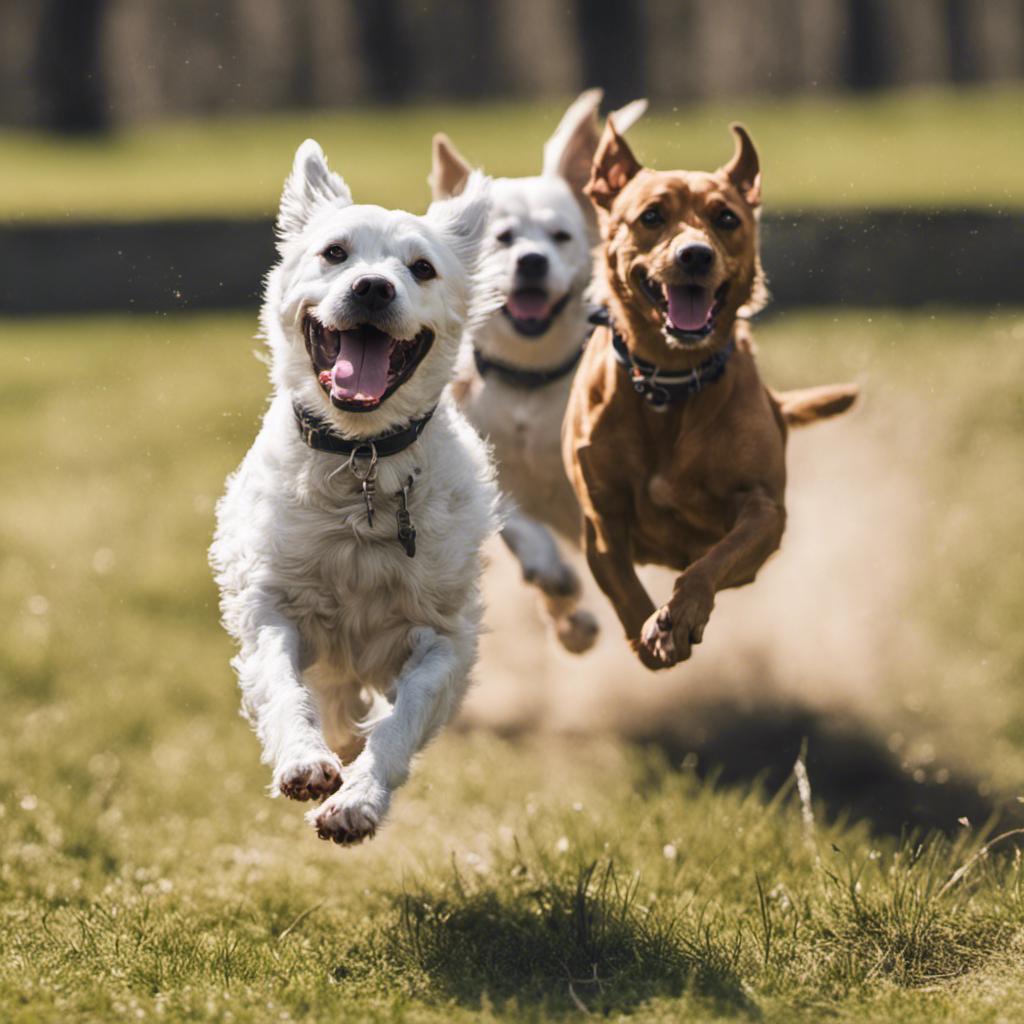

Bedrock/Batch-Inference/output/6rjp4wyz6zsh/stability.stable-diffusion-xl-v1.000000000001.1.png


In [21]:
# import json

# if "titan" in model_id:
#     output_key = f"{output_dir}/{model_id}.jsonl.out"
#     binary_contents = get_content_binary(output_key)

#     for line in BytesIO(binary_contents):
#         content = json.loads(line.decode("utf-8"))
#         # finish_reason = content.get("error")
#         # if finish_reason is not None: print(f"Image generation error. Error is {finish_reason}")
#         print(content.get("modelInput").get("textToImageParams").get("text"))
#         base64_image = content.get("modelOutput").get("images")[0]
#         base64_bytes = base64_image.encode('ascii')
#         image_bytes = base64.b64decode(base64_bytes)
#         display_image(image_bytes)
# elif "stable" in model_id:
#     for record_id in range(number_of_images):
#         output_key = f"{output_dir}/{model_id}.{str(record_id).zfill(12)}.1.png"
#         binary_contents = get_content_binary(output_key)
#         print(output_key)
#         display_image(binary_contents)

In [18]:
# jobs = bedrock.list_model_invocation_jobs().get("invocationJobSummaries")
# from pprint import pprint
# # pprint(jobs)
# for job in jobs:
#     # a = f"{job.get("jobArn")}"
#     print(job)

In [19]:
# i600 = jobs[1]
# i600

In [20]:
# (i600.get("lastModifiedTime") - i600.get("submitTime")) / 600